In [1]:
import pecnet as pc
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from models import Model, FinalModel

In [2]:
import tensorflow as tf
import os 
import random
#This is for getting the same results. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [3]:
def read(station, start, end):
    if isinstance(start, datetime):
        start = np.datetime64(start)
    if isinstance(end, datetime):
        end = np.datetime64(end)

    path = f'{station}_1min.dat'
    with open(path, "rb") as file:
        file.seek(int((start-np.datetime64('2000-01-01'))/np.timedelta64(1, 'm'))*4)
        minutes = int((end-start)/np.timedelta64(1, 'm'))
        data = np.frombuffer(file.read(minutes*4), np.float32)
    times = np.arange(start, end, np.timedelta64(1, 'm'))
    return times, data

In [4]:
start = np.datetime64('2002-01-01') # enter time range
end = np.datetime64('2012-12-31') # 2000 to 2040 time range
DATA_FOLDER = "data/"
STATION_NAME = "54_SAK_UNIV_PROB"

timesSignal, dataSignal = read(DATA_FOLDER + STATION_NAME, start, end)
energy = pd.read_csv("energy_release.csv", index_col=0).fillna(0).reset_index()
energy["date"] = pd.to_datetime(energy["index"])
efd_df = pd.DataFrame({"value":dataSignal}, index=timesSignal)
#drop_idx = np.argwhere(efd_df.index == pd.to_datetime("2012-12-31 00:00:00")).flatten()[0]#Drop last day
#efd_df = efd_df.iloc[:drop_idx].copy()
energy["E_weekly_mean"] = np.flip(pc.rolling_op(np.flip(energy["E_daily"].to_numpy()), 7, np.nanmean))
energy = energy.drop(0).reset_index(drop=True)

In [5]:
df = energy.copy()
df["prev7days"] = pc.rolling_op(energy["E_weekly_mean"].values, 7, np.nanmean, fill=True, step=1)
df["y_aftersplit"] = np.append(df["prev7days"].values[1:], [0])
df.head(20)

,index,E_daily,date,E_weekly_mean,prev7days,y_aftersplit
0,2002-01-02,0.000000,2002-01-02,440.552234,62.936033,137.290479
1,2002-01-03,0.000000,2002-01-03,520.481120,137.290479,230.453128
2,2002-01-04,1125.226719,2002-01-04,652.138545,230.453128,309.115677
3,2002-01-05,834.055745,2002-01-05,550.637839,309.115677,383.373619
4,2002-01-06,0.000000,2002-01-06,519.805599,383.373619,467.965299
5,2002-01-07,506.353109,2002-01-07,592.141757,467.965299,542.223242
6,2002-01-08,618.230063,2002-01-08,519.805599,542.223242,556.332820
7,2002-01-09,559.502202,2002-01-09,539.319281,556.332820,547.605574
8,2002-01-10,921.601976,2002-01-10,459.390395,547.605574,509.725630
9,2002-01-11,414.721779,2002-01-11,386.978938,509.725630,493.286686


In [6]:
pd.set_option('max_colwidth', 160)
df2 = df.copy()
df2["prev7days"] =  pc.rolling_op(energy["E_daily"].values, 7, np.nanmean, fill=True, step=1, include_first=False)
DAILY_WINDOW = 8
ENERGY_SPLIT_INDEX= int(energy.shape[0] / 100 * 80)
seventh_data = energy.E_daily.to_numpy().flatten()
X_7, y_7 = pc.get_xy(seventh_data, DAILY_WINDOW, step =1, fill=True, include_first=False)
df2 = df2.drop(columns=["y_aftersplit"])
#df2["y_aftersplit"] = np.append(y_train_7, y_test_7)
df2["X_7"] = [str(x) for x in X_7]
df2["y_7"] = y_7
df2.head(20)

,index,E_daily,date,E_weekly_mean,prev7days,X_7,y_7
0,2002-01-02,0.000000,2002-01-02,440.552234,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],0.000000
1,2002-01-03,0.000000,2002-01-03,520.481120,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],1125.226719
2,2002-01-04,1125.226719,2002-01-04,652.138545,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],834.055745
3,2002-01-05,834.055745,2002-01-05,550.637839,160.746674,[ 0. 0. 0. 0. 0.\n 0. 0. 1125.2267188],0.000000
4,2002-01-06,0.000000,2002-01-06,519.805599,279.897495,[ 0. 0. 0. 0. 0.\n 0. 1125.2267188 834.0557446],506.353109
5,2002-01-07,506.353109,2002-01-07,592.141757,279.897495,[ 0. 0. 0. 0. 0.\n 1125.2267188 834.0557446 0. ],618.230063
6,2002-01-08,618.230063,2002-01-08,519.805599,352.233653,[ 0. 0. 0. 0. 1125.2267188\n 834.0557446 0. 506.3531092],559.502202
7,2002-01-09,559.502202,2002-01-09,539.319281,440.552234,[ 0. 0. 0. 1125.2267188 834.0557446\n 0. 506.3531092 618.2300628],921.601976
8,2002-01-10,921.601976,2002-01-10,459.390395,520.481120,[ 0. 0. 1125.2267188 834.0557446 0.\n 506.3531092 618.2300628 559.5022024],414.721779
9,2002-01-11,414.721779,2002-01-11,386.978938,652.138545,[ 0. 1125.2267188 834.0557446 0. 506.3531092\n 618.2300628 559.5022024 921.6019761],618.230063


In [7]:
seventh_data = energy.E_daily.to_numpy().flatten()
X,y = pc.get_xy(seventh_data, 4, step=1, fill=True, include_first=False)
X2,y2 = pc.get_xy(seventh_data, 8, step=1, fill=True, include_first=False)
print(X.shape, y.shape, X2.shape, y2.shape)
df3 = df2[["date","E_daily", "E_weekly_mean"]].copy()
df3["windows"]= [str(np.round(x)) for x in X]
df3["y"] = y
df3["windows2"]= [str(np.round(x)) for x in X2]
df3["y2"] = y2
df3.head(20)

(4017, 4) (4017,) (4017, 8) (4017,)


,date,E_daily,E_weekly_mean,windows,y,windows2,y2
0,2002-01-02,0.000000,440.552234,[0. 0. 0. 0.],0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],0.000000
1,2002-01-03,0.000000,520.481120,[0. 0. 0. 0.],1125.226719,[0. 0. 0. 0. 0. 0. 0. 0.],1125.226719
2,2002-01-04,1125.226719,652.138545,[0. 0. 0. 0.],834.055745,[0. 0. 0. 0. 0. 0. 0. 0.],834.055745
3,2002-01-05,834.055745,550.637839,[ 0. 0. 0. 1125.],0.000000,[ 0. 0. 0. 0. 0. 0. 0. 1125.],0.000000
4,2002-01-06,0.000000,519.805599,[ 0. 0. 1125. 834.],506.353109,[ 0. 0. 0. 0. 0. 0. 1125. 834.],506.353109
5,2002-01-07,506.353109,592.141757,[ 0. 1125. 834. 0.],618.230063,[ 0. 0. 0. 0. 0. 1125. 834. 0.],618.230063
6,2002-01-08,618.230063,519.805599,[1125. 834. 0. 506.],559.502202,[ 0. 0. 0. 0. 1125. 834. 0. 506.],559.502202
7,2002-01-09,559.502202,539.319281,[834. 0. 506. 618.],921.601976,[ 0. 0. 0. 1125. 834. 0. 506. 618.],921.601976
8,2002-01-10,921.601976,459.390395,[ 0. 506. 618. 560.],414.721779,[ 0. 0. 1125. 834. 0. 506. 618. 560.],414.721779
9,2002-01-11,414.721779,386.978938,[506. 618. 560. 922.],618.230063,[ 0. 1125. 834. 0. 506. 618. 560. 922.],618.230063


In [8]:
means = []
stds = []

group = efd_df.groupby(pd.Grouper(freq='22.5min', label='right', closed='right'))
mean_efd = group.mean()
stds_efd = group.std()
means.append(mean_efd.reset_index().iloc[:-1])
stds.append(stds_efd.reset_index().iloc[:-1])

freqs = ["3h","1d"]
for freq in freqs:
    group_mean = mean_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))
    group_std = stds_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))

    means.append(group_mean.max().reset_index().iloc[:-1])
    stds.append(group_std.max().reset_index().iloc[:-1])

freqs = ["22.5min", "3h","1d"]

In [9]:
split_idx = int(energy.shape[0] / 100 * 80)
print(split_idx)

3213


In [10]:
for i, mean_df in enumerate(means):
    print(freqs[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])

/var/folders/vx/yk4t77mx6vd042k1kmqpvls80000gn/T/ipykernel_54657/2136075922.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  print(freqs[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])


22.5min index    2010-10-20 00:00:00
value           10610.703125
Name: 205696, dtype: object
3h index    2010-10-20 00:00:00
value           10611.897461
Name: 25712, dtype: object
1d index    2010-10-20 00:00:00
value              10617.375
Name: 3214, dtype: object


In [11]:
# FIRST_SPLIT_INDEX = 205696
# SECOND_SPLIT_INDEX = 25712
# THIRD_SPLIT_INDEX = 3214

ENERGY_SPLIT_INDEX = split_idx
HOURLY_WINDOW = 8 # Last 3 hours
DAILY_WINDOW = 8 # Last 1 day
WEEKLY_WINDOW = 8 # Last 8 days

FIRST_STEP = int(24*60 / 22.5) # 64
SECOND_STEP = int(24*60 / (22.5 * 8))
THIRD_STEP = 1 # 64

HOURLY_START = FIRST_STEP  - HOURLY_WINDOW
DAILY_START  = SECOND_STEP - DAILY_WINDOW 
WEEKLY_START = THIRD_STEP  - WEEKLY_WINDOW # Its minus -7, So you can either fill the data, or cut the first 7 days(need to convert to their freq) from the other ones

op = np.nanmean
first_data =  means[2].value.to_numpy().flatten()
second_data = stds[2].value.to_numpy().flatten()

third_data = means[1].value.to_numpy().flatten()
fourth_data = stds[1].value.to_numpy().flatten()

fifth_data = means[0].value.to_numpy().flatten()
sixth_data = stds[0].value.to_numpy().flatten()

output_data = energy.E_weekly_mean.to_numpy().flatten()

# we don't use y_train s and y_test s 
X_train, X_test, y_train, y_test, mean = pc.prepare_and_split_data(first_data, window_size=WEEKLY_WINDOW, mean_window_size=WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)
X_train_2, X_test_2, y_train_2, y_test_2, mean_2 = pc.prepare_and_split_data(second_data, window_size=WEEKLY_WINDOW, mean_window_size=WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

X_train_3, X_test_3, y_train_3, y_test_3, mean_3 = pc.prepare_and_split_data(third_data[DAILY_START:], window_size=DAILY_WINDOW, mean_window_size=DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_4, X_test_4, y_train_4, y_test_4, mean_4 = pc.prepare_and_split_data(fourth_data[DAILY_START:], window_size=DAILY_WINDOW, mean_window_size=DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)

X_train_5, X_test_5, y_train_5, y_test_5, mean_5 = pc.prepare_and_split_data(fifth_data[HOURLY_START:], window_size=HOURLY_WINDOW,  mean_window_size=HOURLY_WINDOW, step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_6, X_test_6, y_train_6, y_test_6, mean_6 = pc.prepare_and_split_data(sixth_data[HOURLY_START:], window_size=HOURLY_WINDOW,  mean_window_size=HOURLY_WINDOW, step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as y_train
y_train_7, y_test_7 = pc.label_train_test(y=output_data, split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as X_train (we cannot use y_train_7 and y_test_7 since prepare_and_split_data() does normalization + wavelet)
seventh_data = energy.E_daily.to_numpy().flatten()
X_train_7, X_test_7, _, _, mean_7 = pc.prepare_and_split_data(seventh_data, window_size=DAILY_WINDOW, mean_window_size=DAILY_WINDOW, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

In [12]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7)
(804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7)


In [13]:
#Remove NaN
nan_mask_train = np.isnan(X_train).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_2).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_3).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_4).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_5).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_6).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_7).any(axis=1)

nan_mask_test = np.isnan(X_test).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_2).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_3).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_4).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_5).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_6).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_7).any(axis=1)

In [14]:
#We will only use X_train and X_tests for efd
#y values for energy
X_train   = X_train[~nan_mask_train]
X_train_2 = X_train_2[~nan_mask_train]
X_train_3 = X_train_3[~nan_mask_train]
X_train_4 = X_train_4[~nan_mask_train]
X_train_5 = X_train_5[~nan_mask_train]
X_train_6 = X_train_6[~nan_mask_train]
X_train_7 = X_train_7[~nan_mask_train]

X_test   = X_test[~nan_mask_test]
X_test_2 = X_test_2[~nan_mask_test]
X_test_3 = X_test_3[~nan_mask_test]
X_test_4 = X_test_4[~nan_mask_test]
X_test_5 = X_test_5[~nan_mask_test]
X_test_6 = X_test_6[~nan_mask_test]
X_test_7 = X_test_7[~nan_mask_test]

# select ER as label
y_train = y_train_7[~nan_mask_train]
y_test  = y_test_7[~nan_mask_test]

# drop na's from means
mean_7 = mean_7[~np.append(nan_mask_train, nan_mask_test)]
mean = mean[~np.append(nan_mask_train, nan_mask_test)]

# normalize label
y_train = y_train - mean_7[:len(y_train)]
y_test = y_test - mean_7[len(y_train):]


In [15]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(2764, 7) (2764, 7) (2764, 7) (2764, 7) (2764, 7) (2764, 7) (2764, 7)
(788, 7) (788, 7) (788, 7) (788, 7) (788, 7) (788, 7) (788, 7)


In [16]:
#For creating the between networks
def create_network(X_train, y_train, X_test, y_test, mean, Model, model_name, y_train_real=None, compensated_train=None, compensated_test=None, first=False):
    model = Model(X_train.shape, y_train.shape)
    model.set_model_info(model_name)
    model.set_fit_args()
    model.init_model()

    #model.model.summary()
    hist = model.fit_model(X_train, y_train, verbose=False)

    #Predict for model
    predict_train = model.predict(X_train).flatten()
    predict_test = model.predict(X_test).flatten()
    if first:
        #compensated_train = predict_train + mean[:X_train.shape[0]]
        #compensated_test = predict_test +mean[X_train.shape[0]:]
        
        # don't include mean to calculation
        compensated_train = predict_train
        compensated_test = predict_test
        error_train = predict_train - y_train
        error_test = predict_test - y_test
        return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test
    #Calculate compensated errors
    compensated_train = compensated_train - predict_train
    compensated_test = compensated_test - predict_test
    #Calculate error for model.
    error_train = compensated_train - y_train_real
    error_test = compensated_test - y_test

    return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test

## PECNET INPUT:EFD, OUTPUT:ENERGY

In [17]:
out_first = create_network(X_train, y_train, X_test, y_test, mean, Model, "First Model", first=True)
(hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test) = out_first

25/25 [==============================] - 0s 292us/step


In [18]:
out_second = create_network(X_train_2, error_train, X_test_2, y_test, mean, Model, "Second Model", y_train_real = y_train, compensated_train=compensated_train, compensated_test=compensated_test, first=False)
(hist_2, predict_train_2, predict_test_2, error_train_2, error_test_2, compensated_train_2, compensated_test_2) = out_second

25/25 [==============================] - 0s 301us/step


In [19]:
out_third = create_network(X_train_3, error_train_2, X_test_3, y_test, mean, Model, "Third Model", y_train_real = y_train, compensated_train=compensated_train_2, compensated_test=compensated_test_2, first=False)
(hist_3, predict_train_3, predict_test_3, error_train_3, error_test_3, compensated_train_3, compensated_test_3) = out_third

25/25 [==============================] - 0s 3ms/step


In [20]:
out_fourth = create_network(X_train_4, error_train_3, X_test_4, y_test, mean, Model, "Fourth Model", y_train_real = y_train, compensated_train=compensated_train_3, compensated_test=compensated_test_3, first=False)
(hist_4, predict_train_4, predict_test_4, error_train_4, error_test_4, compensated_train_4, compensated_test_4) = out_fourth

25/25 [==============================] - 0s 753us/step


In [21]:
out_fifth = create_network(X_train_5, error_train_4, X_test_5, y_test, mean, Model, "Fifth Model", y_train_real = y_train, compensated_train=compensated_train_4, compensated_test=compensated_test_4, first=False)
(hist_5, predict_train_5, predict_test_5, error_train_5, error_test_5, compensated_train_5, compensated_test_5) = out_fifth

25/25 [==============================] - 0s 326us/step


In [22]:
out_sixth = create_network(X_train_6, error_train_5, X_test_6, y_test, mean, Model, "Sixth Model", y_train_real = y_train, compensated_train=compensated_train_5, compensated_test=compensated_test_5, first=False)
(hist_6, predict_train_6, predict_test_6, error_train_6, error_test_6, compensated_train_6, compensated_test_6) = out_sixth

25/25 [==============================] - 0s 550us/step


In [23]:
#Error Network

ERROR_ALIGNMENT = 0
ERROR_WINDOW_SIZE = 24
X_train_error, y_train_error, mean_train_error = pc.prepare_data(np.append([0], error_train_6), window_size = ERROR_WINDOW_SIZE, mean_window_size=ERROR_WINDOW_SIZE, normalize=True, fill=True, is_error_data=True)
X_test_error, y_test_error, mean_test_error = pc.prepare_data(np.append([0], error_test_6), window_size = ERROR_WINDOW_SIZE, mean_window_size=ERROR_WINDOW_SIZE, normalize=True, fill=True, is_error_data=True)

#Error network
error_model = Model(X_train_error.shape, y_train_error.shape)
error_model.set_model_info("Error Model")
error_model.set_fit_args()
error_model.init_model()
# error_model.model.summary()
hist_error = error_model.fit_model(X_train_error, y_train_error, verbose=False)

#Predict for error Model
predict_train_error = error_model.model.predict(X_train_error).flatten()
predict_test_error = error_model.model.predict(X_test_error).flatten()

#Calculate compensated errors.
compensated_train_error = compensated_train_6[ERROR_ALIGNMENT:] - (predict_train_error + mean_train_error)
compensated_test_error = compensated_test_6 - (predict_test_error + mean_test_error)

#Calculate error for error model.
error_train_error = (predict_train_error  + mean_train_error)
error_test_error = (predict_test_error + mean_test_error)

25/25 [==============================] - 0s 335us/step


In [24]:
#Create Final Network IO
#ERROT_ALIGNMENT: if not zero
X_train_final = np.column_stack((predict_train, predict_train_2, predict_train_3, predict_train_4, predict_train_5, predict_train_6, error_train_error)) 
X_test_final = np.column_stack((predict_test, predict_test_2, predict_test_3, predict_test_4, predict_test_5, predict_test_6, error_test_error))

y_train_final = y_train[ERROR_ALIGNMENT:]
y_test_final = y_test

In [25]:
#Final model
final_model = FinalModel(X_train_final.shape, y_train_final.shape)
final_model.set_model_info("Final Model")
final_model.set_fit_args()
final_model.init_model()
# final_model.model.summary()
hist_final = final_model.fit_model(X_train_final, y_train_final, verbose=False)

#Predict the values
predict_train_final = final_model.predict(X_train_final).flatten()
predict_test_final = final_model.predict(X_test_final).flatten()
#Add mean
predict_train_final = predict_train_final + mean_7[:y_train.shape[0]]
predict_test_final = predict_test_final + mean_7[y_train.shape[0]:]
y_train_plot = y_train + mean_7[:y_train.shape[0]]
y_test_plot = y_test + mean_7[y_train.shape[0]:]

# predict_train_final = predict_train_final
# predict_test_final = predict_test_final
# y_train_plot = y_train
# y_test_plot = y_test

predict_test_final=predict_test_final.clip(min=0)
predict_train_final=predict_train_final.clip(min=0)

25/25 [==============================] - 0s 371us/step


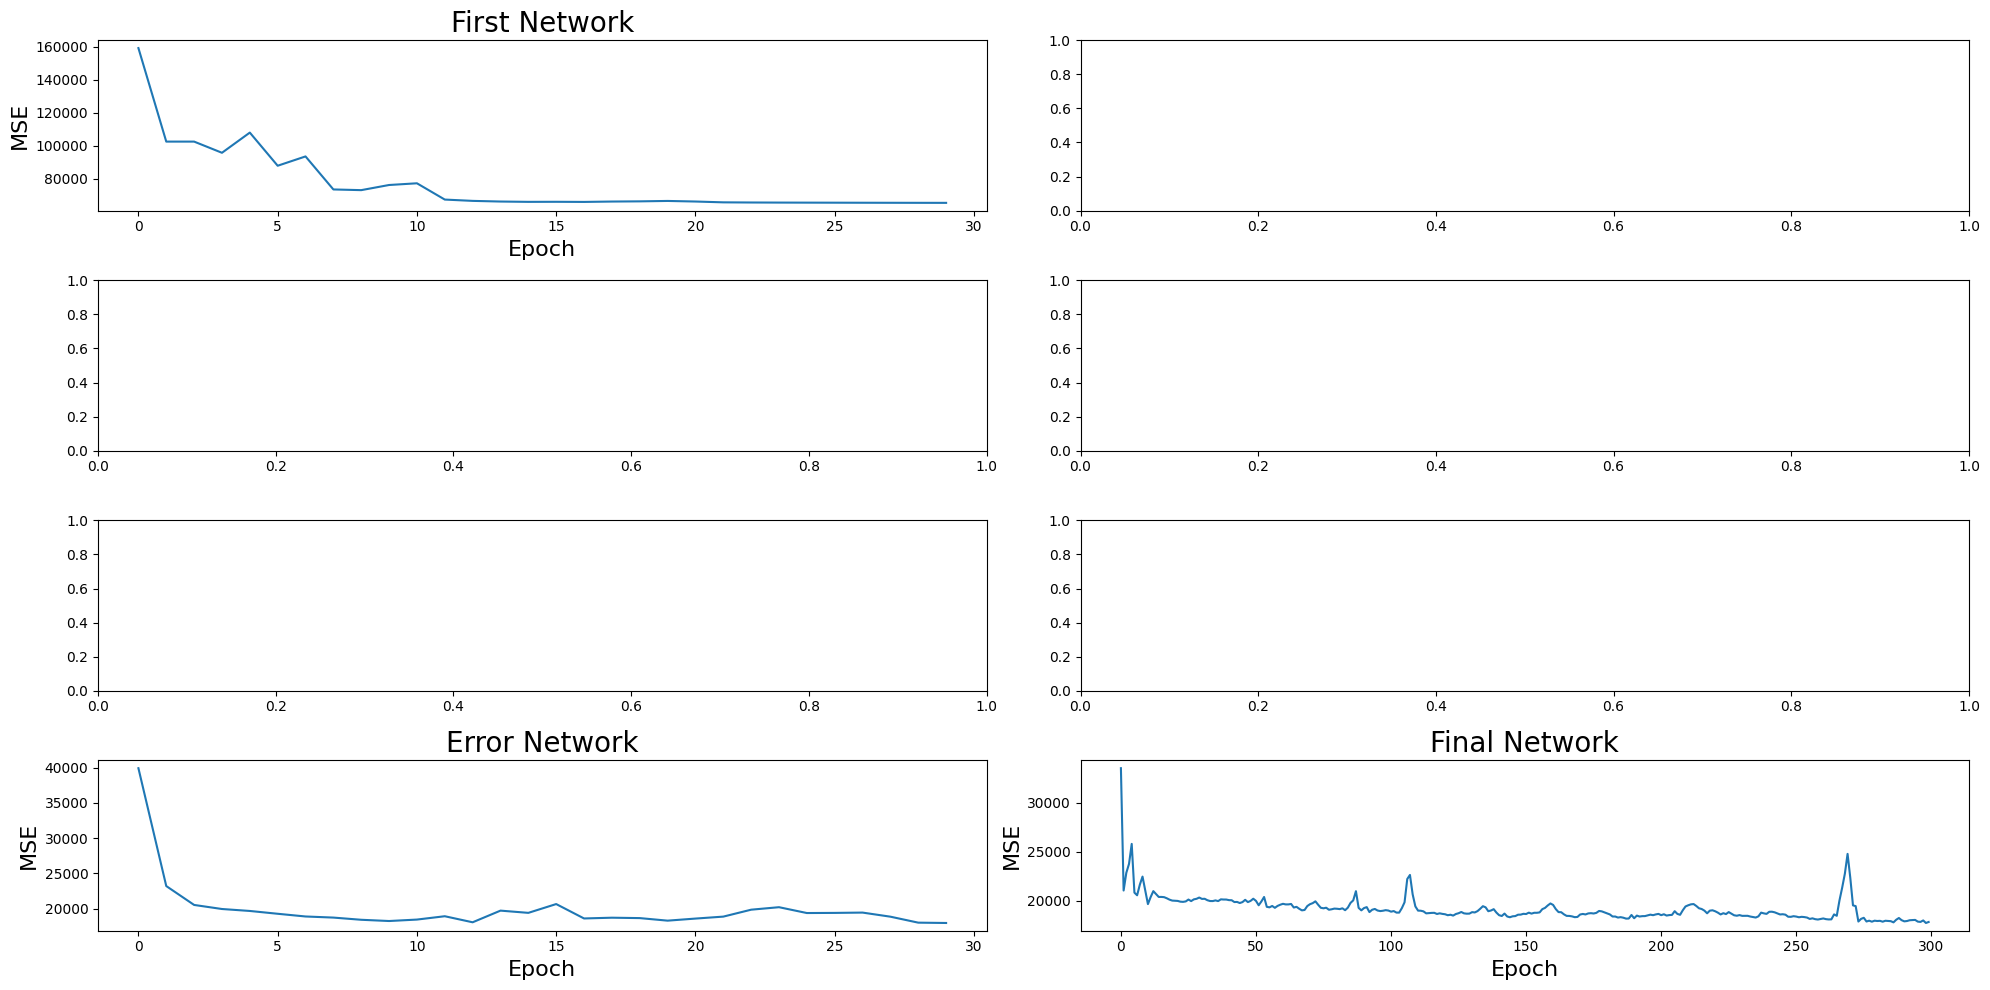

In [26]:
fig, ((ax0,ax1),(ax2,ax3), (ax4,ax5), (ax6,ax7)) = plt.subplots(4,2, figsize=(20,10))

metric = "loss"
x_title = "MSE"
ax0.plot(hist.history[metric])
ax0.set_title("First Network", fontsize=20)
ax0.set_xlabel("Epoch", fontsize=16)
ax0.set_ylabel(x_title, fontsize=16)

ax6.plot(hist_error.history[metric])
ax6.set_title("Error Network", fontsize=20)
ax6.set_xlabel("Epoch", fontsize=16)
ax6.set_ylabel(x_title, fontsize=16)

ax7.plot(hist_final.history[metric])
ax7.set_title("Final Network", fontsize=20)
ax7.set_xlabel("Epoch", fontsize=16)
ax7.set_ylabel(x_title, fontsize=16)


plt.tight_layout()
plt.show()

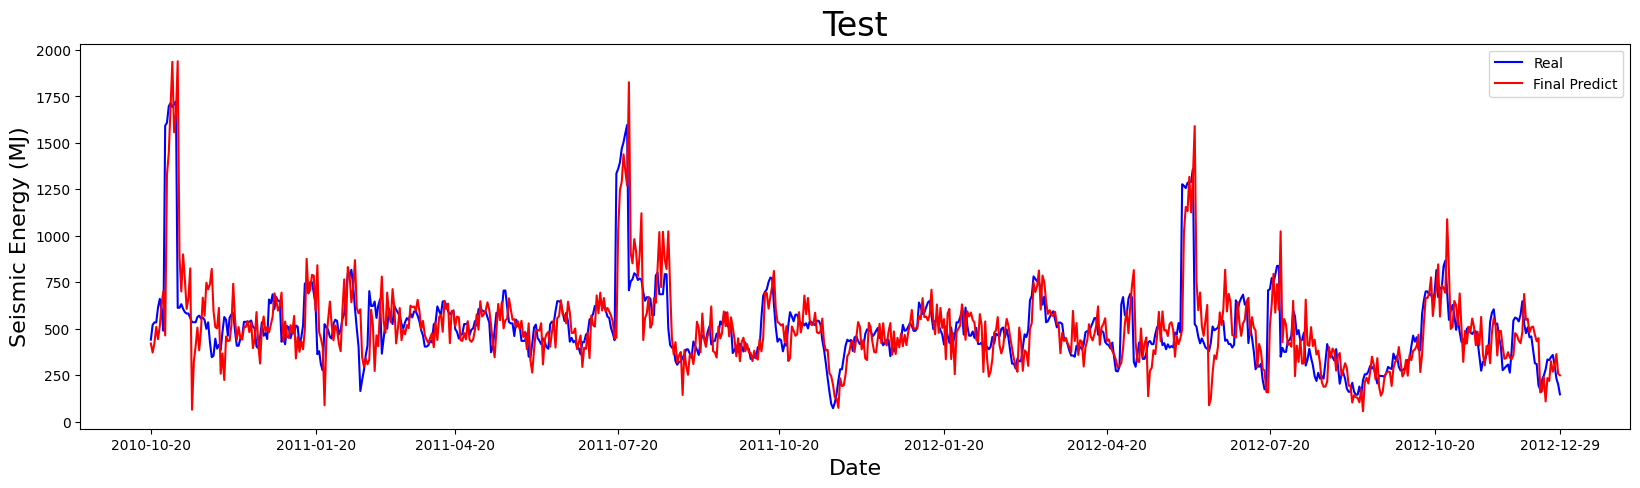

In [27]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("Test", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (MJ)", fontsize=16)
ticks = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
labels = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
ax = plt.gca()

plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), y_test_plot, c='b', label="Real")
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_final, c='r', label="Final Predict")
plt.legend()

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

In [28]:
energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str).to_numpy()[-1]

'2012-12-29'

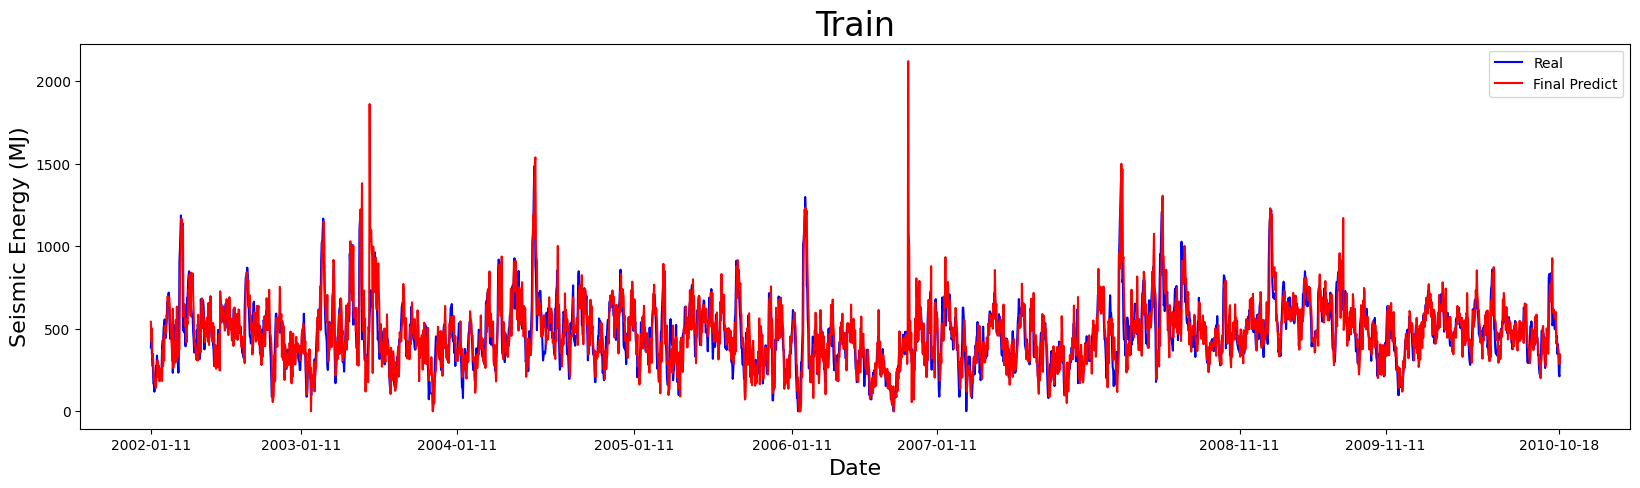

In [29]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("Train", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (MJ)", fontsize=16)
ticks = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11", "2008-11-11", "2009-11-11","2010-10-18"]
labels = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11","2008-11-11","2009-11-11", "2010-10-18"]
ax = plt.gca()
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), y_train_plot, c='b', label="Real")
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_final, c='r', label="Final Predict")
plt.legend()
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

In [30]:
print("R2\t", "Train: ", r2_score(y_train_plot[1:], y_train_plot[:-1]), "\tTest: ", r2_score(y_test_plot[1:], y_test_plot[:-1]))

R2	 Train:  0.7820614514348594 	Test:  0.7468583985244548


In [31]:
#shifting
for i in range(1,10):
    print("R2", "i=", i, "\t", "Train: ", r2_score(y_train_plot[:-i], predict_train_final[i:]), "\tTest: ", r2_score(y_test_plot[:-i], predict_test_final[i:]))

R2 i= 1 	 Train:  0.7191002870004493 	Test:  0.7856790214783222
R2 i= 2 	 Train:  0.6132494611423889 	Test:  0.6817235025476702
R2 i= 3 	 Train:  0.44542211055393366 	Test:  0.505380577261225
R2 i= 4 	 Train:  0.24486321022706392 	Test:  0.35148784822880785
R2 i= 5 	 Train:  0.041887297386495104 	Test:  0.14555273291242588
R2 i= 6 	 Train:  -0.17753270504535368 	Test:  -0.049767318549453377
R2 i= 7 	 Train:  -0.37748932225140197 	Test:  -0.23516042172815732
R2 i= 8 	 Train:  -0.577877774482406 	Test:  -0.4812436113089109
R2 i= 9 	 Train:  -0.7203446624933678 	Test:  -0.6699587516243948


In [32]:
print("R2\t", "Train: ", r2_score(y_train_plot, predict_train_final), "\tTest: ", r2_score(y_test_plot[:-1], predict_test_final[:-1]))
print("RMSE\t", "Train: ", mean_squared_error(y_train_plot, predict_train_final, squared=False), "\tTest: ", mean_squared_error(y_test_plot[:-1], predict_test_final[:-1],  squared=False))
print("MAPE\t", "Train: ", mean_absolute_percentage_error(y_train_plot, predict_train_final), "\tTest: ", mean_absolute_percentage_error(y_test_plot[:-1], predict_test_final[:-1]))

R2	 Train:  0.4993480074437615 	Test:  0.44192975408766866
RMSE	 Train:  132.2007159032259 	Test:  157.95362389706904
MAPE	 Train:  1263287919573026.0 	Test:  0.2195849518351641


# POST PROCESSING

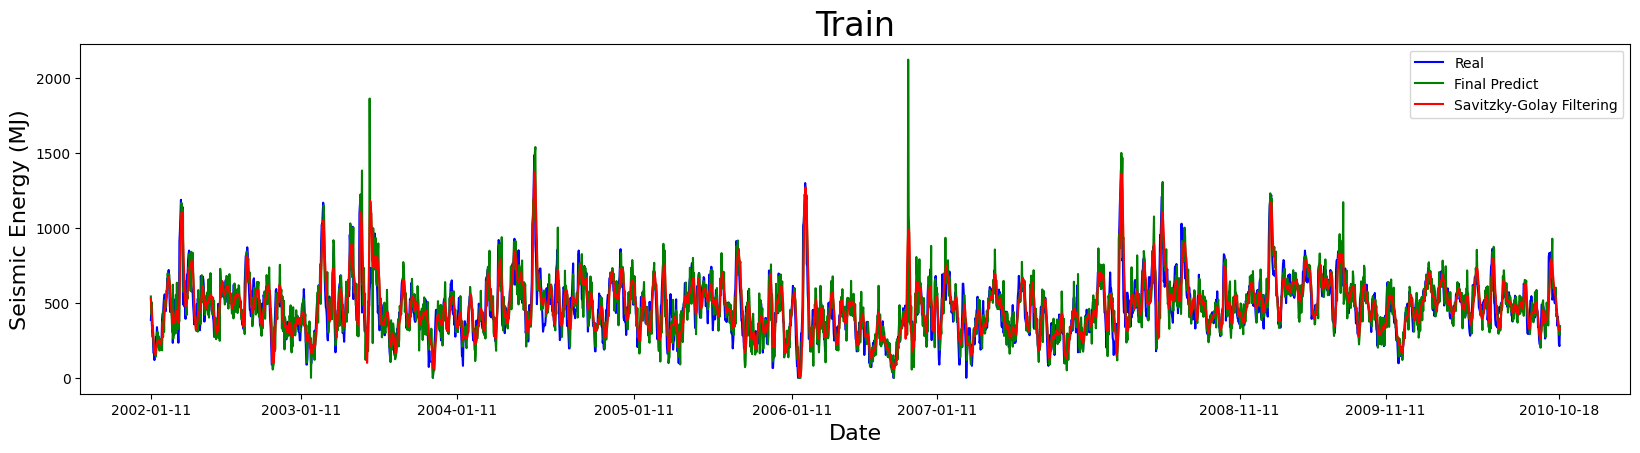

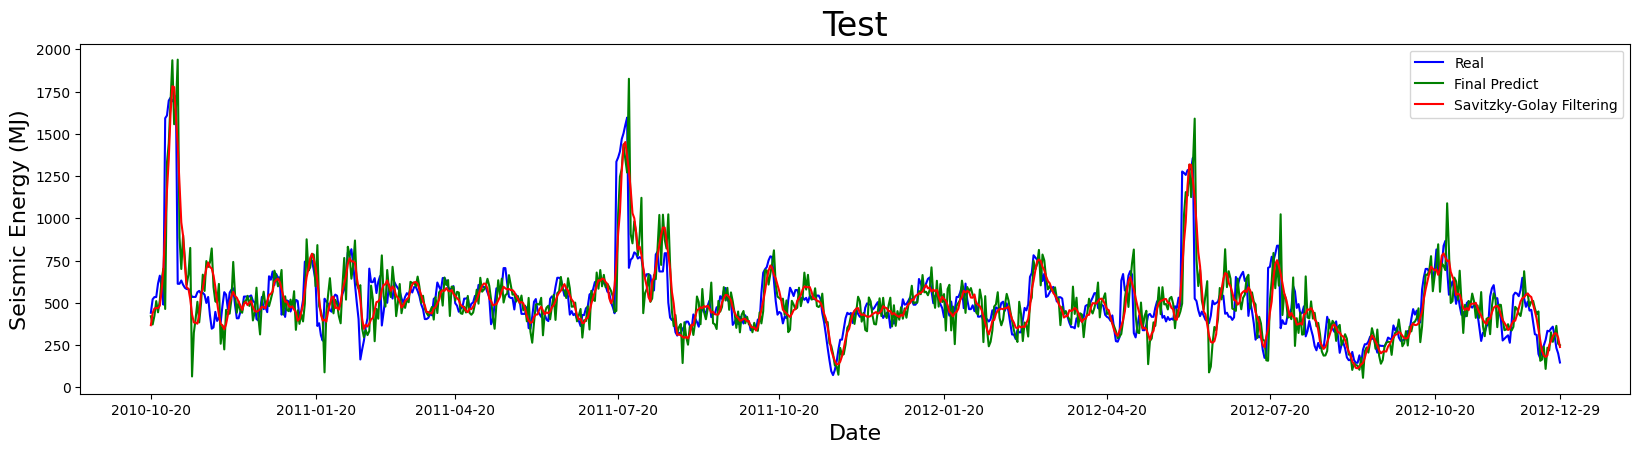

R2	 Train:  0.7144266829025057 	Test:  0.6898269712949783
RMSE	 Train:  99.84461474433138 	Test:  117.75711999863516


In [33]:
from scipy.signal import savgol_filter

# Savitzky-Golay Filtering (window=11, order=3)
window_length = 11
poly_order = 3
predict_test_final_smoothed_sg = savgol_filter(predict_test_final, window_length, poly_order)
predict_train_final_smoothed_sg = savgol_filter(predict_train_final, window_length, poly_order)

# PLOTS
plt.figure(figsize=(20,10), dpi=100)
plt.subplot(2, 1, 1)
plt.title("Train", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (MJ)", fontsize=16)
ticks = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11", "2008-11-11", "2009-11-11","2010-10-18"]
labels = ["2002-01-11", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11","2008-11-11","2009-11-11", "2010-10-18"]
ax = plt.gca()
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), y_train_plot, c='b', label="Real")
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_final, c='g', label="Final Predict")
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train].astype(str), predict_train_final_smoothed_sg, c='r', label="Savitzky-Golay Filtering")
plt.legend()
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

plt.figure(figsize=(20,10), dpi=100)
plt.subplot(2, 1, 2)
plt.title("Test", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (MJ)", fontsize=16)
ticks = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
labels = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-29"]
ax = plt.gca()
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), y_test_plot, c='b', label="Real")
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_final, c='g', label="Final Predict")
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test].astype(str), predict_test_final_smoothed_sg, c='r', label="Savitzky-Golay Filtering")
plt.legend()
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)
plt.show()

# RESULTS FOR SMOOTHING METHOD
print("R2\t", "Train: ", r2_score(y_train_plot, predict_train_final_smoothed_sg), "\tTest: ", r2_score(y_test_plot[:-1], predict_test_final_smoothed_sg[:-1]))
print("RMSE\t", "Train: ", mean_squared_error(y_train_plot, predict_train_final_smoothed_sg, squared=False), "\tTest: ", mean_squared_error(y_test_plot[:-1], predict_test_final_smoothed_sg[:-1],  squared=False))

## LIMITED EVALUATION

In [34]:
# evaluate the model only with values greate than 4
def evaluate_model(y_real, y_pred, limit=4):
    # calculate energy release of the limit
    er_limit = round(2 ** (5.24 + 1.44 * limit),7)
    y_real_limited = y_real[y_real >= er_limit]
    y_pred_limited = y_pred[y_real >= er_limit]
    print("len(y_real_limited)", len(y_real_limited))
    print("len(y_pred_limited)", len(y_pred_limited))
    if len(y_real_limited) == 0 or len(y_pred_limited) == 0:
        raise Exception("No values greater than limit")
    else:
        return r2_score(y_real_limited, y_pred_limited), mean_squared_error(y_real_limited, y_pred_limited, squared=False), mean_absolute_percentage_error(y_real_limited, y_pred_limited)

In [35]:
print("original size of y_train_plot", len(y_train_plot))
print("original size of y_test_plot", len(y_test_plot))

original size of y_train_plot 2764
original size of y_test_plot 788


In [36]:
train_r2, train_rmse, train_mape = evaluate_model(y_train_plot, predict_train_final, limit=1.5)
test_r2, test_rmse, test_mape = evaluate_model(y_test_plot[:-1], predict_test_final[:-1], limit=1.5)

print("R2\t", "Train: ", train_r2, "\tTest: ", test_r2)
print("RMSE\t", "Train: ", train_rmse, "\tTest: ", test_rmse)
print("MAPE\t", "Train: ", train_mape, "\tTest: ", test_mape)

len(y_real_limited) 2671
len(y_pred_limited) 2671
len(y_real_limited) 775
len(y_pred_limited) 775
R2	 Train:  0.4402519085918558 	Test:  0.4217181719406369
RMSE	 Train:  132.39633576337874 	Test:  158.16774366752634
MAPE	 Train:  0.22120744543689064 	Test:  0.21263150721722923


In [37]:
train_r2, train_rmse, train_mape = evaluate_model(y_train_plot, predict_train_final, limit=2)
test_r2, test_rmse, test_mape = evaluate_model(y_test_plot[:-1], predict_test_final[:-1], limit=2)

print("R2\t", "Train: ", train_r2, "\tTest: ", test_r2)
print("RMSE\t", "Train: ", train_rmse, "\tTest: ", test_rmse)
print("MAPE\t", "Train: ", train_mape, "\tTest: ", test_mape)

len(y_real_limited) 2388
len(y_pred_limited) 2388
len(y_real_limited) 730
len(y_pred_limited) 730
R2	 Train:  0.32764762083372767 	Test:  0.36811246545048004
RMSE	 Train:  133.90743372890265 	Test:  160.79028303610946
MAPE	 Train:  0.20010692165358326 	Test:  0.20289427362744467


In [38]:
train_r2, train_rmse, train_mape = evaluate_model(y_train_plot, predict_train_final, limit=3)
test_r2, test_rmse, test_mape = evaluate_model(y_test_plot[:-1], predict_test_final[:-1], limit=3)

print("R2\t", "Train: ", train_r2, "\tTest: ", test_r2)
print("RMSE\t", "Train: ", train_rmse, "\tTest: ", test_rmse)
print("MAPE\t", "Train: ", train_mape, "\tTest: ", test_mape)

len(y_real_limited) 161
len(y_pred_limited) 161
len(y_real_limited) 46
len(y_pred_limited) 46
R2	 Train:  -0.44125300744402285 	Test:  0.3601736388751595
RMSE	 Train:  199.74391932156564 	Test:  287.3270773108747
MAPE	 Train:  0.167465223820566 	Test:  0.16178008410234304
